In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2"

In [2]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.data.all import *
from fastai2.data.core import *
from fastai2.distributed import *
from fastai2.data.transforms import *


In [3]:
from reformer_pytorch import Reformer, ReformerLM
from itertools import product

In [4]:
#import numpy as np
import random
#from tqdm import tqdm
import gc
from sklearn.model_selection import GroupKFold
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)



In [5]:
# configurations and main hyperparammeters
SEGMENT_SIZE = 500000 
WINDOW_SIZE = 200
BS = torch.cuda.device_count() * 64
SPLITS = 5
DIM = 220

assert SEGMENT_SIZE % WINDOW_SIZE == 0
assert (SEGMENT_SIZE // WINDOW_SIZE) % SPLITS == 0
SEED = 321
DATA_SUFFIX = '_clean'

p_input = Path('input')

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [6]:
# read data
train_dtypes = {'time': np.float32, 'signal': np.float32, 'open_channels': np.int32 }
test_dtypes  = {'time': np.float32, 'signal': np.float32 }
df_train  = pd.read_csv(p_input / f'train.csv', dtype= train_dtypes)
df_test   = pd.read_csv(p_input / f'test.csv',  dtype= test_dtypes)
df_train_drift = pd.read_csv(p_input / f'train{DATA_SUFFIX}.csv', dtype= train_dtypes)
df_test_drift  = pd.read_csv(p_input / f'test{DATA_SUFFIX}.csv',  dtype= test_dtypes)
sub   = pd.read_csv(p_input / 'sample_submission.csv',  dtype={'time': np.float32})
df_train['drift'] = df_train['signal'] - df_train_drift['signal']
df_test['drift']  = df_test['signal']  - df_test_drift['signal']

In [7]:
df_train['signal'] =  df_train_drift['signal']
df_test['signal']  =   df_test_drift['signal']

In [8]:
len(df_train),SEGMENT_SIZE

(5000000, 500000)

In [9]:
df_train['open_channels'][2300000:2400000][(df_train['open_channels'][2300000:2400000]==0)]=1

In [10]:
d_xtra_csvs = {
    1: ['outfinaltest10.csv',  'outfinaltest44.csv',],#  'outfinaltest78.csv',],  'outfinaltest10.csv',  'outfinaltest44.csv'],
    3: ['outfinaltest1.csv',   'outfinaltest2.csv',   'outfinaltest3.csv',   'outfinaltest4.csv', 'outfinaltest5.csv'],
    5: ['outfinaltest328.csv', 'outfinaltest534.csv', 'outfinaltest747.csv',]#, 'outfinaltest328.csv', 'outfinaltest534.csv']
}

df_train_xtra = None
for _,xtra_csvs in d_xtra_csvs.items():
    print(_,xtra_csvs)
    for xtra_csv in xtra_csvs:
        xx = pd.read_csv(p_input / xtra_csv , header=None,names=['time', 'signal', 'open_channels'])
        df_train_xtra = pd.concat((xx,df_train_xtra), axis=0)
df_train_xtra['drift']  = 0.
#df_train = pd.concat((df_train,df_train_xtra), axis=0)

1 ['outfinaltest10.csv', 'outfinaltest44.csv']
3 ['outfinaltest1.csv', 'outfinaltest2.csv', 'outfinaltest3.csv', 'outfinaltest4.csv', 'outfinaltest5.csv']
5 ['outfinaltest328.csv', 'outfinaltest534.csv', 'outfinaltest747.csv']


In [11]:
train = torch.cat((torch.FloatTensor(df_train['signal'        ].values).unsqueeze(0),
                   torch.FloatTensor(df_train['drift'         ].values).unsqueeze(0),
                   torch.FloatTensor(df_train['open_channels' ].values).unsqueeze(0)))
test  = torch.cat((torch.FloatTensor(df_test ['signal'        ].values).unsqueeze(0),
                   torch.FloatTensor(df_test ['drift'         ].values).unsqueeze(0)))
signal = torch.cat((train[0],test[0]))
signal_mean, signal_std = signal.mean(),signal.std()
train[0] = (train[0] - signal_mean) / signal_std
test[0]  = ( test[0] - signal_mean) / signal_std
train = train.view(train.shape[0],-1,SEGMENT_SIZE)
test  =  test.view( test.shape[0],-1,SEGMENT_SIZE)

In [12]:
def build_lag_lead(x,DIM):
    w = DIM//2
    ws = x.shape[-1]
    r = math.ceil(w/ws) + 1
    x_lead  = x.repeat(1,1,r)[...,:ws+w-1]
    x_lag   = x.repeat(1,1,r).flip((2))[...,:ws+w-1]
    lead,lag=x_lead.unfold(2,w,1), x_lag.unfold(2,w,1).flip((2))
    return torch.cat((lead,lag),dim=3)#.squeeze(1)#.permute(0,2,1)

train = build_lag_lead(train,DIM)
test  = build_lag_lead(test,DIM)

In [13]:
train.shape,test.shape

(torch.Size([3, 10, 500000, 220]), torch.Size([2, 4, 500000, 220]))

In [14]:
s=0


In [15]:
train_channels_in_segment=torch.zeros((len(df_train)//SEGMENT_SIZE,11))
for i,s in enumerate(range(0,len(df_train),SEGMENT_SIZE)):
    train_channels_in_segment[i] = torch.histc(FloatTensor(df_train['open_channels'][s:s+SEGMENT_SIZE].values),11,0,11)/SEGMENT_SIZE
    #channels_hot = torch.zeros(11,11)
    #channels_hot = channels_hot.scatter(0,channels.unsqueeze(0), 1.).sum(dim=1)
    #train_channels_in_segment.append(channels_hot)
assert len(train_channels_in_segment)*SEGMENT_SIZE == train.shape[1]*train.shape[2]
train_channels_in_segment

tensor([[9.6827e-01, 3.1732e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [9.6132e-01, 3.8676e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.5201e-01, 7.4799e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.3556e-02, 1.7386e-01, 4.3377e-01, 3.6882e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.1800e-04, 1.0520e-03, 6.8520e-03, 2.9250e-02, 9.0290e-02,
         1.8556e-01, 2.6464e-01, 2.4649e-01, 1.3930e-01, 3.6456e-02],
        [1.9120e-03, 2.3464e-02, 1.1847e-01, 2.9467e-01, 3.7516e-01, 1.8633e-01,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.4639e-01, 7.5361e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.00

In [16]:
test_channels_in_segment = FloatTensor([
    [1,1,0,0,0,0,0,0,0,0,0], # A
    [1,1,1,1,0,0,0,0,0,0,0], # B
    [0,1,1,1,1,1,0,0,0,0,0], # C
    [1,1,0,0,0,0,0,0,0,0,0], # D
    [1,1,0,0,0,0,0,0,0,0,0], # E
    [0,0,0,0,1,1,1,1,1,1,1], # F
    [1,1,1,1,1,1,0,0,0,0,0], # G
    [0,0,0,0,1,1,1,1,1,1,1], # H
    [1,1,0,0,0,0,0,0,0,0,0], # I
    [1,1,1,1,0,0,0,0,0,0,0], # J
    [1,1,0,0,0,0,0,0,0,0,0], # 
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
    [1,1,0,0,0,0,0,0,0,0,0],  
])
test_channels_in_segment = test_channels_in_segment.unsqueeze(0).repeat(100000//SEGMENT_SIZE,1,1).transpose(0,1).reshape(-1,11)
#assert test_channels_in_segment.shape[0]*SEGMENT_SIZE == test.shape[1]*test.shape[2]
test_channels_in_segment.shape

torch.Size([0, 11])

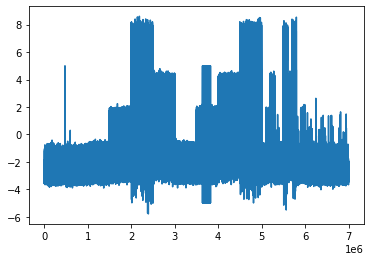

In [17]:
plt.plot(signal)

In [18]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 300
rcParams['agg.path.chunksize'] = 10000

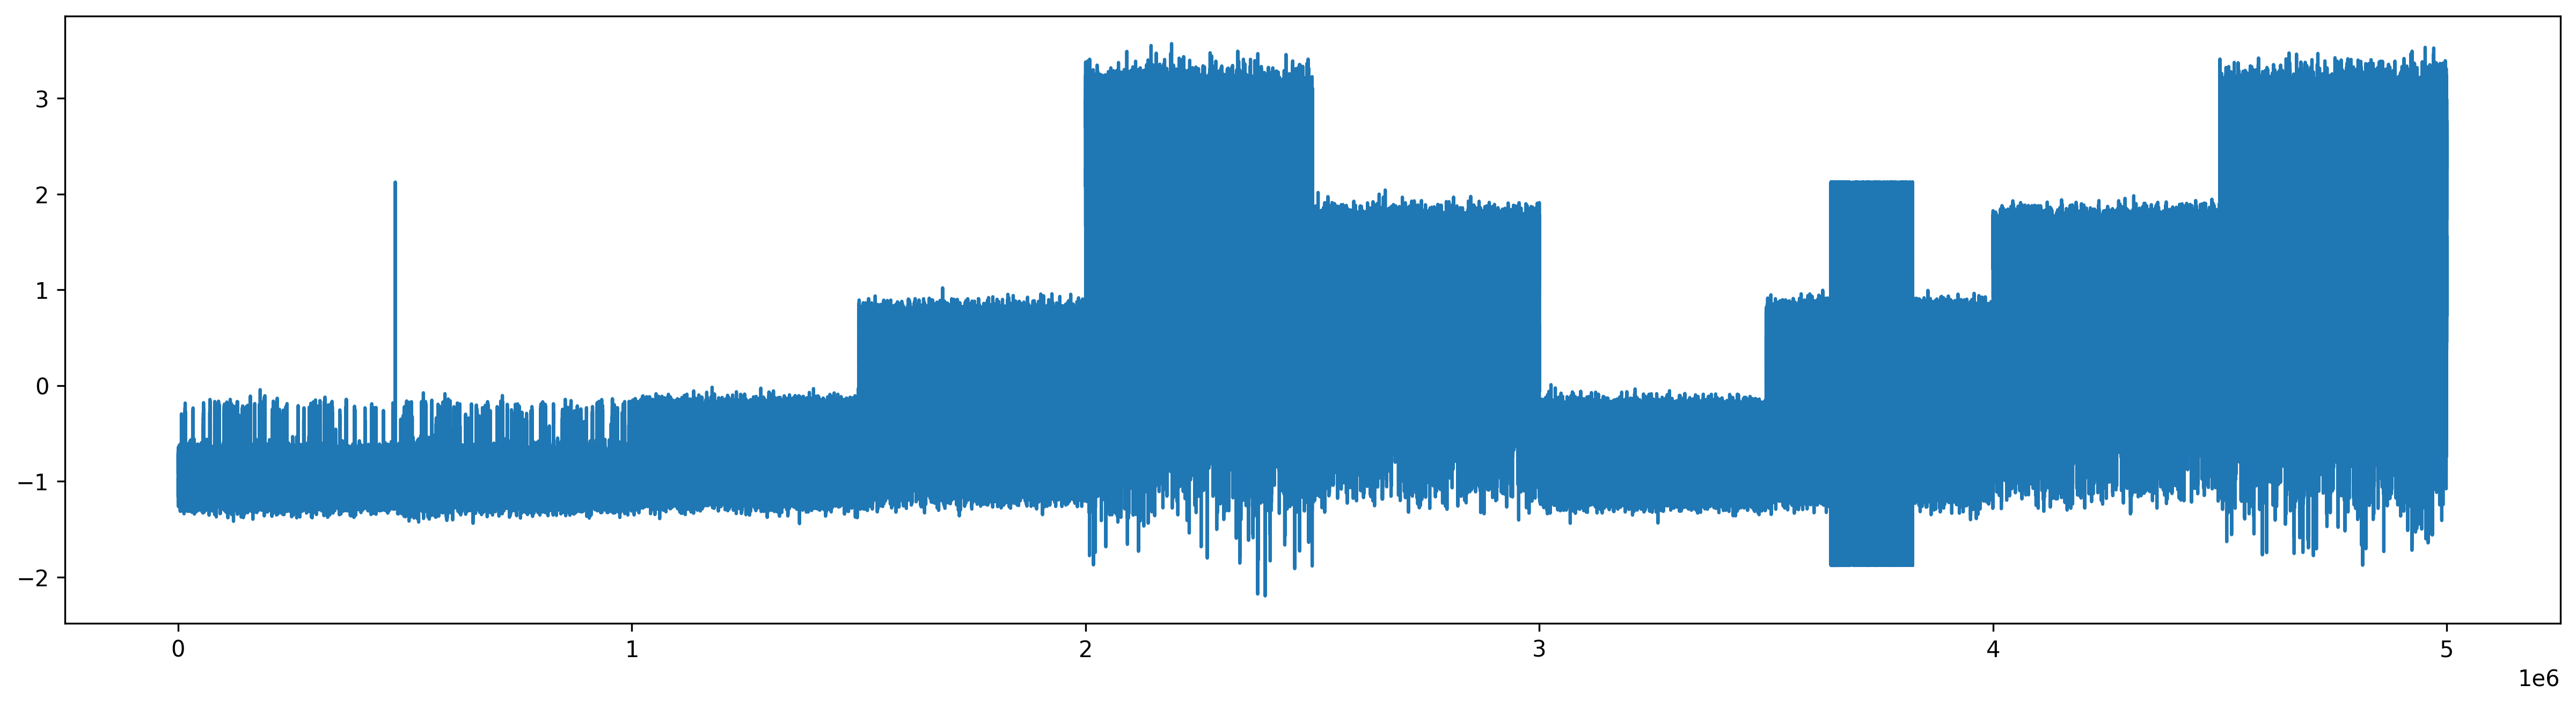

In [19]:
plt.plot(train[0,...,0].flatten())

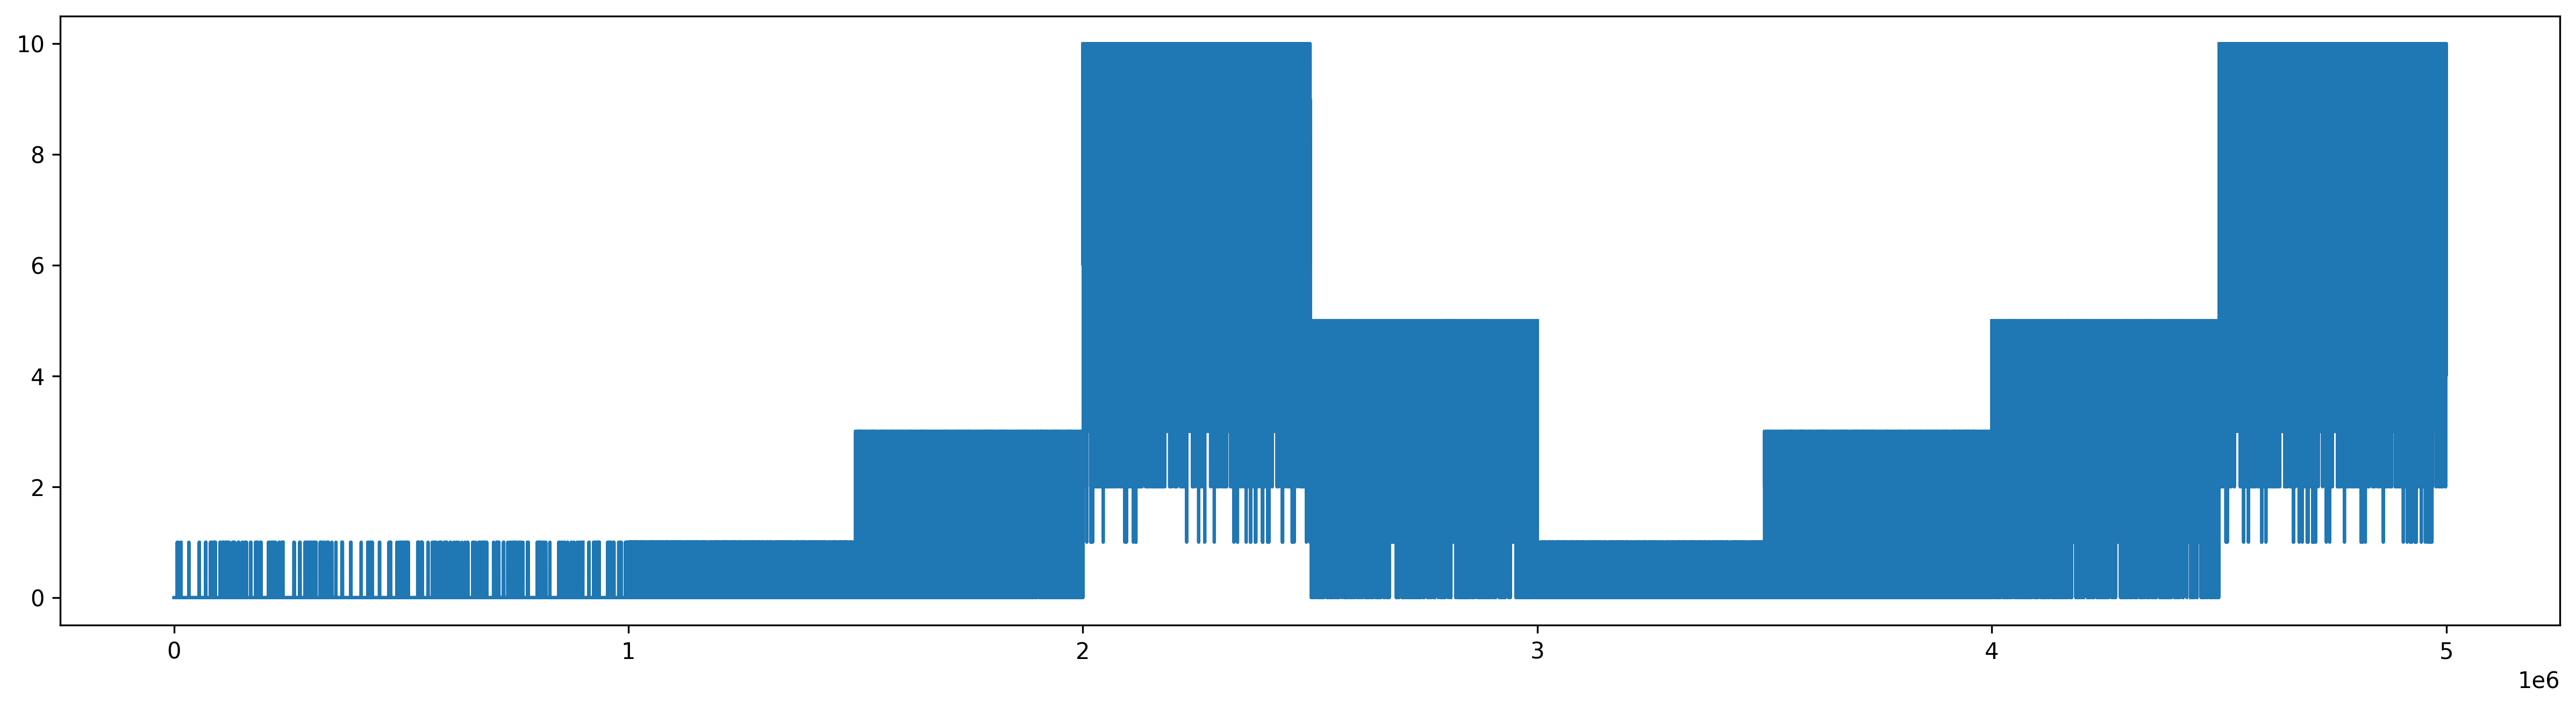

In [20]:
plt.plot(train[2,...,0].flatten())

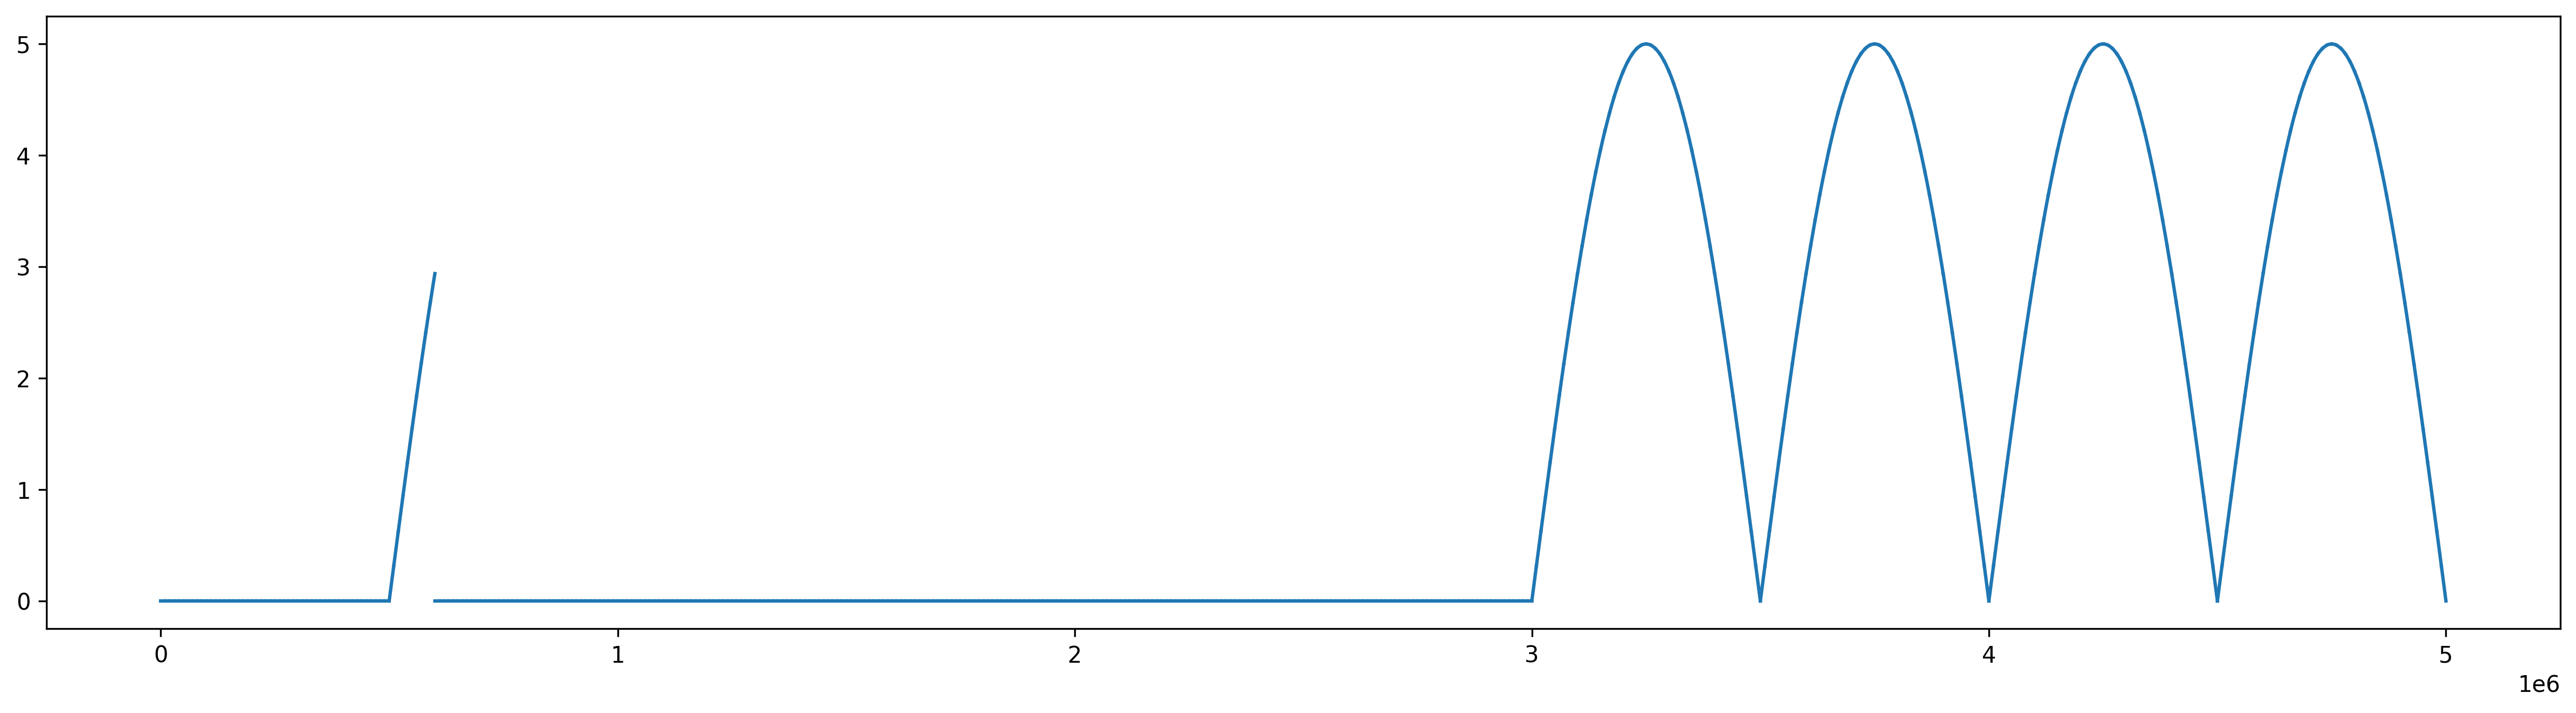

In [21]:
plt.plot(train[1,...,0].flatten())

In [22]:
split = 0
split_size = SEGMENT_SIZE//WINDOW_SIZE//SPLITS
valid_idx = split*split_size + np.arange(split_size)
train_idx = np.setdiff1d(np.arange(SEGMENT_SIZE//WINDOW_SIZE), valid_idx)
train_idx, valid_idx = list(product(range(train.shape[1]),train_idx)), list(product(range(train.shape[1]),valid_idx))
train_idx[:10],train_idx[10:]

([(0, 500),
  (0, 501),
  (0, 502),
  (0, 503),
  (0, 504),
  (0, 505),
  (0, 506),
  (0, 507),
  (0, 508),
  (0, 509)],
 [(0, 510),
  (0, 511),
  (0, 512),
  (0, 513),
  (0, 514),
  (0, 515),
  (0, 516),
  (0, 517),
  (0, 518),
  (0, 519),
  (0, 520),
  (0, 521),
  (0, 522),
  (0, 523),
  (0, 524),
  (0, 525),
  (0, 526),
  (0, 527),
  (0, 528),
  (0, 529),
  (0, 530),
  (0, 531),
  (0, 532),
  (0, 533),
  (0, 534),
  (0, 535),
  (0, 536),
  (0, 537),
  (0, 538),
  (0, 539),
  (0, 540),
  (0, 541),
  (0, 542),
  (0, 543),
  (0, 544),
  (0, 545),
  (0, 546),
  (0, 547),
  (0, 548),
  (0, 549),
  (0, 550),
  (0, 551),
  (0, 552),
  (0, 553),
  (0, 554),
  (0, 555),
  (0, 556),
  (0, 557),
  (0, 558),
  (0, 559),
  (0, 560),
  (0, 561),
  (0, 562),
  (0, 563),
  (0, 564),
  (0, 565),
  (0, 566),
  (0, 567),
  (0, 568),
  (0, 569),
  (0, 570),
  (0, 571),
  (0, 572),
  (0, 573),
  (0, 574),
  (0, 575),
  (0, 576),
  (0, 577),
  (0, 578),
  (0, 579),
  (0, 580),
  (0, 581),
  (0, 582),
  (

In [23]:
#train_idx = np.arange(SEGMENT_SIZE//WINDOW_SIZE)
#valid_idx = train_idx
#train_idx, valid_idx = list(product(range(train.shape[1]),train_idx)), list(product(range(train.shape[1]),valid_idx))


In [24]:
class IonDataset(torch.utils.data.Dataset):
    def __init__(self, data,idx=None,jitter=False,p_flip=0.):
        super().__init__()
        self.data, self.channels_in_segment,self.jitter,self.p_flip = *data, jitter, p_flip
        self.idx = ifnone(idx,list(product(range(self.data.shape[1]),np.arange(SEGMENT_SIZE//WINDOW_SIZE))))
        self.n_inp = 1
        self.has_y = self.data.shape[0] == 3
    def __len__(self): return len(self.idx)
    def __getitem__(self, idx):
        s,o=self.idx[idx]
        jitter = 0
        if self.jitter:
            os,oe = 0,0
            if (s,(o-1)) in self.idx: os = -WINDOW_SIZE//2
            if (s,(o+1)) in self.idx: oe =  WINDOW_SIZE//2
            jitter = torch.randint(os,oe,(1,)).item()
        ss = slice(jitter+o*WINDOW_SIZE,jitter+(o+1)*WINDOW_SIZE)
        x =  self.data[0,s,ss,:]
        segment = self.data[0,s,:,0]
        flip = (torch.rand(1) < self.p_flip).item()
        if flip: x,segment = torch.flip(x,dims=(1,)), torch.flip(segment,dims=(0,))
        x = (x,segment)#self.channels_in_segment[s])
        if self.has_y: 
            y_drift,y_open_channels = (self.data[1,s:s+1,ss,0], self.data[2,s:s+1,ss,0].long())
            if flip: y_drift,y_open_channels=(torch.flip(y_drift,dims=(1,)),torch.flip(y_open_channels,dims=(1,)))
            return (x,(y_drift,y_open_channels))
        return (x,)
    
train_ds = IonDataset((train, train_channels_in_segment), train_idx)#, jitter=True), p_flip=0.5)
valid_ds = IonDataset((train, train_channels_in_segment), valid_idx)
test_ds  = IonDataset((test,  test_channels_in_segment))
train_dl = DataLoader(train_ds, BS, shuffle=True,  num_workers=8, pin_memory=True)
valid_dl = DataLoader(valid_ds, BS, shuffle=False, num_workers=4, pin_memory=True)
test_dl  = DataLoader(test_ds,  BS, shuffle=False, num_workers=8, pin_memory=True)
train_ds[2],train_ds[2][0][1].shape

(((tensor([[-0.8397, -1.0586, -0.7881,  ..., -1.0103, -1.0117, -1.0218],
           [-1.0586, -0.7881, -0.9536,  ..., -0.9546, -1.0103, -1.0117],
           [-0.7881, -0.9536, -0.9418,  ..., -1.0166, -0.9546, -1.0103],
           ...,
           [-1.0802, -1.0435, -1.0058,  ..., -0.8885, -0.9811, -0.7409],
           [-1.0435, -1.0058, -0.8169,  ..., -0.9605, -0.8885, -0.9811],
           [-1.0058, -0.8169, -0.9988,  ..., -0.7768, -0.9605, -0.8885]]),
   tensor([-0.9803, -1.0187, -0.8392,  ..., -1.0578, -0.9853, -1.0032])),
  (tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0.

In [25]:
test_ds.idx[-10:]

[(3, 2490),
 (3, 2491),
 (3, 2492),
 (3, 2493),
 (3, 2494),
 (3, 2495),
 (3, 2496),
 (3, 2497),
 (3, 2498),
 (3, 2499)]

In [26]:
x =train_ds[0][0][0]
x.shape

torch.Size([200, 220])

In [27]:
dls = DataLoaders(train_dl, valid_dl, test_dl, device=default_device())


In [28]:
class FixedPositionalEmbedding(nn.Module):
    def __init__(self, dim, _):
        super().__init__()
        inv_freq = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, x):
        t = torch.arange(x.shape[1], device=x.device).type(self.inv_freq.type())
        sinusoid_inp = torch.einsum("i,j->ij", t, self.inv_freq)
        emb = torch.cat((sinusoid_inp.sin(), sinusoid_inp.cos()), dim=-1)
        return emb[None, :, :]
    
class AbsolutePositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len):
        super().__init__()
        self.emb = nn.Embedding(max_seq_len, dim)
        self.emb.weight.data.uniform_(-0.01, 0.01)

    def forward(self, x):
        t = torch.arange(x.shape[1], device=x.device)
        return self.emb(t)
    
class DummyDecoder(Module):
    def __init__(self,dropout:float=0):
        self.dropout = nn.Dropout(dropout)

    def forward(self,tgt, memory, tgt_mask=None, memory_mask=None, 
                tgt_key_padding_mask=None, memory_key_padding_mask=None):
        return self.dropout(memory)

    
class DummyEncoder(Module):
    def __init__(self,dropout:float=0):
        self.dropout = nn.Dropout(dropout)

    def forward(self,src, mask=None, src_key_padding_mask=None):
        return self.dropout(src)
    

In [29]:
Activation = Enum('Activation', 'ReLU Swish GeLU')

class PositionalEncoding(Module):
    "Encode the position with a sinusoid."
    def __init__(self, d:int): self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))

    def forward(self, pos:Tensor):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

class GeLU(Module):
    def forward(self, x): return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class Swish(Module):
    def forward(self, x): return x * torch.sigmoid(x)

_activ_func = {Activation.ReLU:nn.ReLU(inplace=True), Activation.GeLU:GeLU(), Activation.Swish: Swish()}

def feed_forward(d_model:int, d_ff:int, ff_p:float=0., act:Activation=Activation.ReLU, double_drop:bool=True):
    layers = [nn.Linear(d_model, d_ff), _activ_func[act]]
    if double_drop: layers.append(nn.Dropout(ff_p))
    return SequentialEx(*layers, nn.Linear(d_ff, d_model), nn.Dropout(ff_p), MergeLayer(), nn.LayerNorm(d_model))

class MultiHeadAttention(Module):
    "MutiHeadAttention."
    def __init__(self, n_heads:int, d_model:int, d_head:int=None, resid_p:float=0., attn_p:float=0., bias:bool=True,
                 scale:bool=True):
        d_head = ifnone(d_head, d_model//n_heads)
        self.n_heads,self.d_head,self.scale = n_heads,d_head,scale
        self.attention = nn.Linear(d_model, 3 * n_heads * d_head, bias=bias)
        self.out = nn.Linear(n_heads * d_head, d_model, bias=bias)
        self.drop_att,self.drop_res = nn.Dropout(attn_p),nn.Dropout(resid_p)
        self.ln = nn.LayerNorm(d_model)

    def forward(self, x:Tensor, mask:Tensor=None, **kwargs):
        return self.ln(x + self.drop_res(self.out(self._apply_attention(x, mask=mask, **kwargs))))

    def _apply_attention(self, x:Tensor, mask:Tensor=None):
        bs,x_len = x.size(0),x.size(1)
        wq,wk,wv = torch.chunk(self.attention(x), 3, dim=-1)
        wq,wk,wv = map(lambda x:x.view(bs, x.size(1), self.n_heads, self.d_head), (wq,wk,wv))
        wq,wk,wv = wq.permute(0, 2, 1, 3),wk.permute(0, 2, 3, 1),wv.permute(0, 2, 1, 3)
        attn_score = torch.matmul(wq, wk)
        if self.scale: attn_score.div_(self.d_head ** 0.5)
        if mask is not None:
            minus_inf = -65504 if attn_score.dtype == torch.float16 else -1e9
            attn_score = attn_score.masked_fill(mask, minus_inf).type_as(attn_score)
        attn_prob = self.drop_att(F.softmax(attn_score, dim=-1))
        attn_vec = torch.matmul(attn_prob, wv)
        return attn_vec.permute(0, 2, 1, 3).contiguous().contiguous().view(bs, x_len, -1)

def _line_shift(x:Tensor, mask:bool=False):
    "Shift the line i of `x` by p-i elements to the left, is `mask` puts 0s on the diagonal."
    bs,nh,n,p = x.size()
    x_pad = torch.cat([x.new_zeros(bs,nh,n,1), x], dim=3)
    x_shift = x_pad.view(bs,nh,p + 1,n)[:,:,1:].view_as(x)
    if mask: x_shift.mul_(torch.tril(x.new_ones(n,p), p-n)[None,None,])
    return x_shift

class DecoderLayer(Module):
    "Basic block of a Transformer model."
    #Can't use Sequential directly cause more than one input...
    def __init__(self, n_heads:int, d_model:int, d_head:int, d_inner:int, resid_p:float=0., attn_p:float=0., ff_p:float=0.,
                 bias:bool=True, scale:bool=True, act:Activation=Activation.ReLU, double_drop:bool=True,
                 attn_cls=MultiHeadAttention):
        self.mhra = attn_cls(n_heads, d_model, d_head, resid_p=resid_p, attn_p=attn_p, bias=bias, scale=scale)
        self.ff   = feed_forward(d_model, d_inner, ff_p=ff_p, act=act, double_drop=double_drop)

    def forward(self, x:Tensor, mask:Tensor=None, **kwargs): return self.ff(self.mhra(x, mask=mask, **kwargs))

class Transformer(Module):
    "Transformer model: https://arxiv.org/abs/1706.03762."
    def __init__(self, n_layers:int, n_heads:int, d_model:int, d_head:int, d_inner:int,
                 resid_p:float=0., attn_p:float=0., ff_p:float=0., embed_p:float=0., bias:bool=True, scale:bool=True,
                 act:Activation=Activation.ReLU, double_drop:bool=True, attn_cls=MultiHeadAttention,
                 learned_pos_enc:bool=True, mask:bool=True, dense_out:bool=False,final_p:float=0.):
        self.mask = mask
        self.drop_final = nn.Dropout(final_p)
        self.dense_out = dense_out
        self.layers = nn.ModuleList([DecoderLayer(n_heads, d_model, d_head, d_inner, resid_p=resid_p, attn_p=attn_p,
                      ff_p=ff_p, bias=bias, scale=scale, act=act, double_drop=double_drop,
                      attn_cls=attn_cls) for k in range(n_layers)])

    def reset(self): pass

    def forward(self, x, mask=None):
        inp = x.permute(1,0,2)
        if mask is not None: mask=mask.permute(1,0,2)
        if self.dense_out: out = x.new()
        for layer in self.layers:
            inp = layer(inp, mask=mask)
            inp_d = self.drop_final(inp)
            if self.dense_out: out = torch.cat([out, inp_d], dim=-1)
        return out.permute(1,0,2) if self.dense_out else inp_d.permute(1,0,2)

In [30]:
torch.randint(10,(1,)).item()

9

In [31]:
class Classiformer(Module):
    def __init__(self, dim, depth, heads, lsh_dropout, bucket_size):
        self.dim = dim
        
        if False:
            self.reformer = Reformer(
                dim = dim,
                depth = depth,
                max_seq_len = WINDOW_SIZE,
                heads = heads,
                lsh_dropout = lsh_dropout,
                bucket_size=bucket_size,
                causal = False
            )
        
        self.transformer = nn.Transformer(
            num_encoder_layers=0,num_decoder_layers=depth,
            nhead=heads,d_model=dim,dim_feedforward=dim*8,dropout=lsh_dropout, 
            custom_encoder=DummyEncoder(dropout=0.))
        
        self.transformer = Transformer(
            n_layers = depth, n_heads=heads, d_model=dim, d_head=dim, d_inner=dim*8, mask=False, 
            attn_p = lsh_dropout)
        
        self.pos_emb = AbsolutePositionalEmbedding(dim, WINDOW_SIZE)
        self.input_to_dim  = nn.Linear(1, dim)

        self.open_channels = nn.Sequential(
            nn.Linear(dim+11, dim//2), nn.ReLU(), 
            nn.Linear(dim//2, dim//4), nn.ReLU(),
            nn.Linear(dim//4, 11))

        self.dim_segment = 100
        
        self.segment_transformer = Transformer(
            n_layers = 4, n_heads=heads, d_model=self.dim_segment, d_head=self.dim_segment*8, 
            d_inner=self.dim_segment, mask=False, attn_p = lsh_dropout)
        
        self.segment_sample = 100000
        self.segment_transformer =Reformer(
                dim = self.dim_segment,
                depth = 4,
                max_seq_len = self.segment_sample,
                heads = 10,
                lsh_dropout = lsh_dropout,
                bucket_size=bucket_size,
                causal = False)
        
        self.drift         = nn.Linear(dim, 1)
        self.open_channels = nn.Linear(dim+self.dim_segment, 11)

        
    def forward(self, x):
        x,segment = x
        # B S D, B 11 
                
        # B 100000
        segment_sample = self.segment_sample
        segment_start = torch.randint(segment.shape[1]-segment_sample,(1,)).item()
        segment = segment[:,segment_start:segment_start+segment_sample]
        segment = segment.view(segment.shape[0],-1,self.dim_segment)
        # B 100 1000

        #segment = segment.permute(1,0,2)
        # 100 B 1000
        segment = self.segment_transformer(segment)
        #segment = segment.permute(1,0,2)
        # B 100 1000
        segment = segment.mean(dim=1)
        # B 1000
        
        #x = x + self.pos_emb(x).type(x.type())
        

        x = x.permute(1,0,2)
        # S B D
        x = self.transformer(x) # S,N,E => T,N,E
                                  # S is the source sequence length, 
                                  # T is the target sequence length, 
                                  # N is the batch size, 
                                  # E is the feature number
        x = x.permute(1,0,2)
        # B S D
        drift         = self.drift(x)
        #x = torch.cat((x,mask_channels.unsqueeze(1).expand(-1,x.shape[1],11)), dim=-1)
        x = torch.cat((x,segment.unsqueeze(1).expand(-1,x.shape[1],-1)), dim=-1)
        open_channels = self.open_channels(x) #- 1000* (1-mask_channels.unsqueeze(1))
        return drift, open_channels
    

class AtomTorchTransformer(Module):
    def __init__(self,n_layers,n_heads,d_model,d_inner,embed_p:float=0,
                 encoder_dropout:float=0,decoder_dropout:float=0,
                 d_head=None,deep_decoder=False,dense_out=False, **kwargs):
        
        self.d_model = d_model
        d_head = ifnone(d_head, d_model//n_heads)        
        
        

In [32]:
dim = DIM
bucket_size = 100
depth = 8
heads = 10
lsh_dropout = 0.

model = ReformerLM(
    num_tokens = 11,
    dim = dim,
    depth = depth,
    max_seq_len = WINDOW_SIZE,
    heads = heads,
    lsh_dropout = lsh_dropout,
    bucket_size=bucket_size,
    causal = False,
    use_full_attn = False,
    fixed_position_emb = False,
    n_hashes = 4,
)
model.token_emb = nn.Linear(1,dim)

In [33]:
model = Classiformer(dim, depth, heads, lsh_dropout, bucket_size)
model

Classiformer(
  (transformer): Transformer(
    (drop_final): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): DecoderLayer(
        (mhra): MultiHeadAttention(
          (attention): Linear(in_features=220, out_features=6600, bias=True)
          (out): Linear(in_features=2200, out_features=220, bias=True)
          (drop_att): Dropout(p=0.0, inplace=False)
          (drop_res): Dropout(p=0.0, inplace=False)
          (ln): LayerNorm((220,), eps=1e-05, elementwise_affine=True)
        )
        (ff): SequentialEx(
          (layers): ModuleList(
            (0): Linear(in_features=220, out_features=1760, bias=True)
            (1): ReLU(inplace=True)
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=1760, out_features=220, bias=True)
            (4): Dropout(p=0.0, inplace=False)
            (5): MergeLayer()
            (6): LayerNorm((220,), eps=1e-05, elementwise_affine=True)
          )
        )
      )
      (1): DecoderLayer(
 

In [34]:
def tversky_loss(logits, true, alpha, beta, eps=1e-7):
    """Computes the Tversky loss [1].
    Args:
        true: a tensor of shape [B, H, W] or [B, 1, H, W].
        logits: a tensor of shape [B, C, H, W]. Corresponds to
            the raw output or logits of the model.
        alpha: controls the penalty for false positives.
        beta: controls the penalty for false negatives.
        eps: added to the denominator for numerical stability.
    Returns:
        tversky_loss: the Tversky loss.
    Notes:
        alpha = beta = 0.5 => dice coeff
        alpha = beta = 1 => tanimoto coeff
        alpha + beta = 1 => F beta coeff
    References:
        [1]: https://arxiv.org/abs/1706.05721
    """
    logits = logits.permute(0,2,1).unsqueeze(-1)
    true = true.unsqueeze(-1)
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = F.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    fps = torch.sum(probas * (1 - true_1_hot), dims)
    fns = torch.sum((1 - probas) * true_1_hot, dims)
    num = intersection
    denom = intersection + (alpha * fps) + (beta * fns)
    tversky_loss = (num / (denom + eps)).mean()
    return (1 - tversky_loss)

class LabelSmoothingCE(Module):
    def __init__(self, eps:float=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        output = output.permute(0,2,1) # => B C S
        target = target.squeeze(1)     # => B S
        log_preds = F.log_softmax(output, dim=1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)
    
class AwareLabelSmoothingCE(Module):
    def __init__(self, eps:float=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction

    def forward(self, output, target):
        c = output.size()[-1]
        output = output.permute(0,2,1) # => B C S
        t_one_hot = torch.zeros(target.shape[0],11,target.shape[2],device=target.device).scatter_(1,target, 1.)
        t_one_hot = t_one_hot.sum(dim=(2,)) > 0. # B C true for classes present in batch
        t_c_per_batch =  t_one_hot.sum(dim=(1,)).float() # B 1 number of classes in each batch
        target = target.squeeze(1)     # => B S
        log_preds = F.log_softmax(output, dim=1) # B C S
        #print(log_preds.shape,t_one_hot.shape,t_c_per_batch.shape)
        #print(log_preds[:2],t_one_hot[:2],t_c_per_batch[:2])
        if self.reduction=='sum': 
            loss = -log_preds.sum()
            assert False
        else:
            loss = (-log_preds*t_one_hot.unsqueeze(-1)/t_c_per_batch.view(-1,1,1)).sum(dim=1) # B C S x B C 1 x B 1 
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)

class DriftChannelsLoss(Module):
    def __init__(self):
        self.drift_loss = MSELossFlat()
        self.open_channels_loss_softf1 = partial(tversky_loss, alpha=0.5,beta=0.5) 
        self.open_channels_loss_ce     = CrossEntropyLossFlat() # LabelSmoothingCE() #CrossEntropyLossFlat() #LabelSmoothingCE()# 
    def __call__(self, input:Tensor, target:Tensor, **kwargs):
        i_drift,i_open_channels = input
        t_drift,t_open_channels = target
        return 0.0*self.drift_loss(i_drift, t_drift) + \
            0.*self.open_channels_loss_softf1(i_open_channels, t_open_channels) + \
            1.*self.open_channels_loss_ce(i_open_channels, t_open_channels) 

In [35]:
import sklearn.metrics as skm

# Cell
class OpenChannelsAccumMetric(Metric):
    "Stores predictions and targets on CPU in accumulate to perform final calculations with `func`."
    def __init__(self, func, dim_argmax=None, sigmoid=False, thresh=None, to_np=False, invert_arg=False,
                 flatten=True, **kwargs):
        store_attr(self,'func,dim_argmax,sigmoid,thresh,flatten')
        self.to_np,self.invert_args,self.kwargs = to_np,invert_arg,kwargs

    def reset(self): self.targs,self.preds = [],[]

    def accumulate(self, learn):
        t,p = learn.y[1],learn.pred[1]
        pred = p.argmax(dim=self.dim_argmax) if self.dim_argmax else p
        if self.sigmoid: pred = torch.sigmoid(pred)
        if self.thresh:  pred = (pred >= self.thresh)
        #pred = p.round()
        targ = t
        pred,targ = to_detach(pred),to_detach(targ)
        if self.flatten: pred,targ = flatten_check(pred,targ)
        self.preds.append(pred)
        self.targs.append(targ)

    @property
    def value(self):
        if len(self.preds) == 0: return
        preds,targs = torch.cat(self.preds),torch.cat(self.targs)
        if self.to_np: preds,targs = preds.numpy(),targs.numpy()
        return self.func(targs, preds, **self.kwargs) if self.invert_args else self.func(preds, targs, **self.kwargs)

    @property
    def name(self):  return self.func.func.__name__ if hasattr(self.func, 'func') else  self.func.__name__

# Cell
def skm_to__open_channels_fastai(func, is_class=True, thresh=None, axis=-1, sigmoid=None, **kwargs):
    "Convert `func` from sklearn.metrics to a fastai metric"
    dim_argmax = axis if is_class and thresh is None else None
    sigmoid = sigmoid if sigmoid is not None else (is_class and thresh is not None)
    return OpenChannelsAccumMetric(func, dim_argmax=dim_argmax, sigmoid=sigmoid, thresh=thresh,
                       to_np=True, invert_arg=True, **kwargs)

def F1Score(axis=-1, labels=None, pos_label=1, average='binary', sample_weight=None):
    "F1 score for single-label classification problems"
    return skm_to__open_channels_fastai(skm.f1_score, axis=axis,
                         labels=labels, pos_label=pos_label, average=average, sample_weight=sample_weight)

def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = inp[1], targ[1]
    pred,targ = flatten_check(pred.argmax(dim=axis), targ)
    return (pred == targ).float().mean()

In [36]:
learn = None
gc.collect()
torch.cuda.empty_cache()
learn = Learner(dls,model,loss_func=DriftChannelsLoss(),opt_func=SGD,
                metrics=[F1Score(labels=list(range(11)),average='macro'), accuracy])
learn.to_parallel().to_fp16()
learn.summary()

Classiformer (Input shape: ["['192 x 200 x 220', '192 x 500000']"])
Layer (type)         Output Shape         Param #    Trainable 
Dropout              192 x 200 x 220      0          False     
________________________________________________________________
Linear               192 x 200 x 6600     1,458,600  True      
________________________________________________________________
Linear               192 x 200 x 220      484,220    True      
________________________________________________________________
Dropout              192 x 10 x 200 x 20  0          False     
________________________________________________________________
Dropout              192 x 200 x 220      0          False     
________________________________________________________________
LayerNorm            192 x 200 x 220      440        True      
________________________________________________________________
Linear               192 x 200 x 1760     388,960    True      
______________________________

In [37]:
modelname = None#'ref_512_16_16_50_0.0_36_400_cv0.9380_clean'
try:
    learn.load(modelname)
except:
    pass

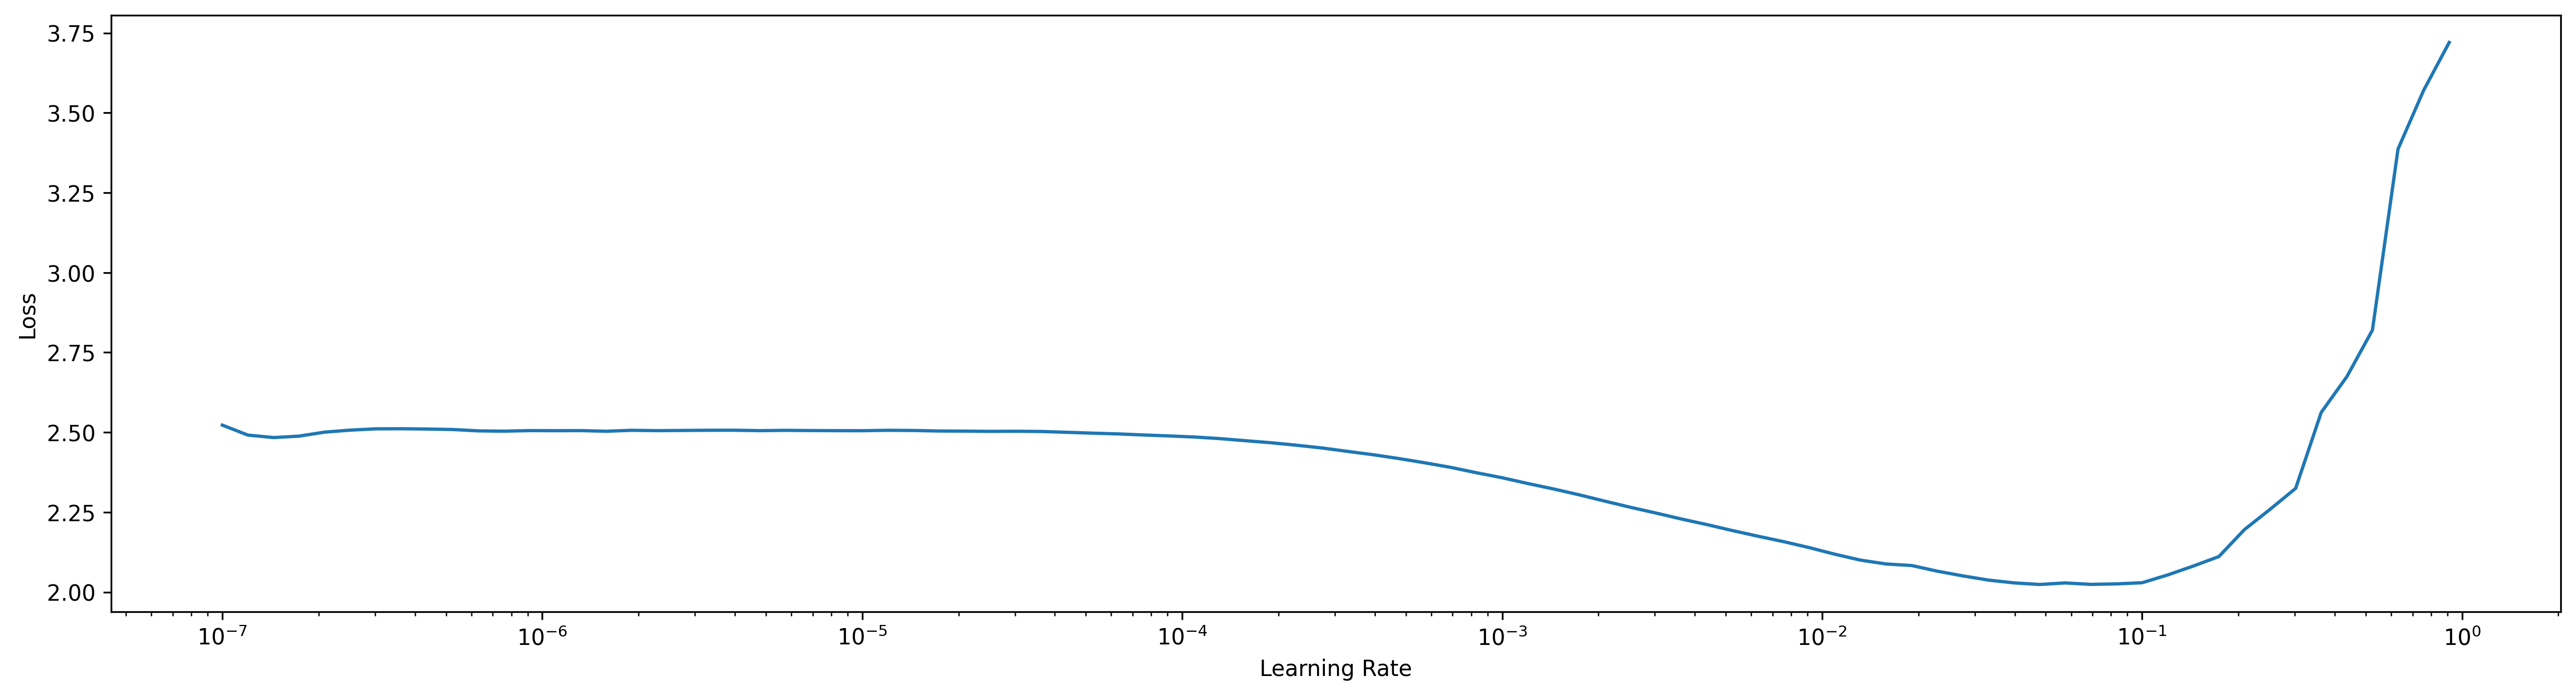

In [38]:
lr_min, lr_steep=learn.lr_find()

In [ ]:
learn.fit_one_cycle(150,lr_max=3e-2)#,pct_start=0.5)

epoch,train_loss,valid_loss,f1_score,accuracy,time
0,1.427674,1.343335,0.228077,0.446168,02:29
1,1.273421,1.218433,0.320697,0.551219,02:28
2,1.166111,1.128836,0.328237,0.551688,02:28
3,1.109304,1.054010,0.350930,0.583349,02:28
4,1.071259,1.199880,0.278951,0.482647,02:28
5,1.033317,0.989497,0.393763,0.616871,02:27
6,0.998420,0.921252,0.416163,0.647395,02:28
7,0.952089,1.000132,0.413439,0.626081,02:28
8,0.900313,0.821165,0.444281,0.690137,02:27
9,0.890478,0.907446,0.428039,0.680336,02:28


In [ ]:
learn.recorder.plot_loss()

In [ ]:
cv,_,time = learn.recorder.log[-3:];cv,_,time

In [ ]:
modelname = f'ref_{dim}_{depth}_{heads}_{bucket_size}_{lsh_dropout}_{BS}_{WINDOW_SIZE}_cv{cv:0.04f}{DATA_SUFFIX}'
learn.save(modelname);modelname

In [ ]:
learn.model.eval()
test_preds = torch.zeros(test[0].numel(),11,dtype=torch.float)
n_tta = 0
with torch.no_grad():
    for flip in [False, True]:
        for i,xx in enumerate(progress_bar(test_dl)):
            x = xx[0]
            if flip: x[0] = torch.flip(x[0], dims=(2,))#x[0].device)
            x = x[0].to(device=default_device()), x[1].to(device=default_device())
            preds = learn.model(x)
            open_channels = preds[1] #- 1000 * (1 - x[1].unsqueeze(1))
            #if i *WINDOW_SIZE*BS > SEGMENT_SIZE*2: print(x[1])
            if flip: open_channels = torch.flip(open_channels, dims=(1,))
            test_preds[i*WINDOW_SIZE*BS:(i+1)*WINDOW_SIZE*BS] += open_channels.view(-1,11).cpu()
        n_tta +=1

In [ ]:
test_preds

In [ ]:
open_channels = test_preds.argmax(dim=1)
open_channels.shape

In [ ]:
plt.plot(open_channels)

In [ ]:
plt.plot(test[0].flatten())

In [ ]:
plt.plot(test[0].flatten())

In [ ]:
csv_fname = f'{modelname}_n_tta{n_tta}.csv';csv_fname

In [ ]:
submission_csv_path = p_input / 'sample_submission.csv'
ss = pd.read_csv(submission_csv_path, dtype={'time': str})
test_preds_all = test_preds
test_pred_frame = pd.DataFrame({'time': ss['time'].astype(str), 'open_channels': open_channels})
test_pred_frame.to_csv(csv_fname, index=False)

In [ ]:
!kaggle competitions submit -c 'liverpool-ion-switching' -f {csv_fname} -m 'trans 1 feat lag/lead jitter flip=0.5 10 epochs '